In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Mon May  9 12:53:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   44C    P8    39W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
    db_rm_cn_5 = db.rm_patent_cn_5
    db_rm_cn_10 = db.rm_patent_cn_10
    db_rm_us_5 = db.rm_patent_us_5
    db_rm_us_10 = db.rm_patent_us_10
    db_rm_de_5 = db.rm_patent_de_5
    db_rm_de_10 = db.rm_patent_de_10
    
except errors.ConnectionFailure as err:
    print(err)

# 後五年

## Company數量

In [6]:
data_assignee = db_rm_de_10.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
# data_assignee = db_rm_cn_10.aggregate([
#     {"$unwind" : "$current_assignee"},
#     {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
#     {"$sort": {"count":-1}},
#     {"$limit":30}
# ])

# ls_company = []
# ls_count = []
# for data in data_assignee:
#     # print(data["_id"],data["count"])
#     ls_company.append(data["_id"])
#     ls_count.append(data["count"])
    
# df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_10.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
33,Qualcomm Inc,4673
38,Samsung Electronics Co Ltd,3412
19,Intel Corp,1886
21,International Business Machines Corp,1510
23,LG Electronics Inc,1420
49,Telefonaktiebolaget LM Ericsson AB,1399
6,Cisco Technology Inc,843
26,Microsoft Technology Licensing LLC,681
2,Apple Inc,498
0,AT&T Intellectual Property I LP,481


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [13]:
com_df.reset_index(drop=True, inplace=True)

In [14]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [15]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [16]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [17]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [18]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [19]:
com_df

,company,count,count_log
0,Qualcomm Inc,4673,8.449557
1,Samsung Electronics Co Ltd,3412,8.135054
2,Intel Corp,1886,7.542213
3,International Business Machines Corp,1510,7.319865
4,LG Electronics Inc,1420,7.258412
5,Telefonaktiebolaget LM Ericsson AB,1399,7.243513
6,Cisco Technology Inc,843,6.736967
7,Microsoft Technology Licensing LLC,681,6.523562
8,Apple Inc,498,6.210600
9,AT&T Intellectual Property I LP,481,6.175867


In [20]:
com_ls = list(com_df.company)

## Data

In [21]:
ccontry = pd.read_csv("./final_data/rm_company_country_de_us_10.csv")

In [22]:
ccpc = pd.read_csv("./final_data/rm_company_cpc_de_us_10.csv")

In [23]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AT,AU,BE,BG,BR,CA,CH,...,SG,SI,TN,TR,TW,UA,US,UY,WO,ZA
66,AT&T Intellectual Property I LP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,568.0,0.0,52.0,0.0
324,Apple Inc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,21.0,0.0,632.0,0.0,454.0,0.0
883,Cisco Technology Inc,0.0,0.0,0.0,6.0,0.0,0.0,0.0,19.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,843.0,0.0,170.0,0.0
1936,Huawei Technologies Co Ltd,0.0,1.0,0.0,21.0,0.0,0.0,74.0,25.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,475.0,0.0,453.0,1.0
2137,Intel Corp,0.0,0.0,0.0,2.0,0.0,0.0,14.0,1.0,0.0,...,5.0,0.0,0.0,0.0,52.0,0.0,1980.0,0.0,813.0,0.0


## Similarity計算

### Country

- 換成機率  

In [24]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [25]:
P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [26]:
# print(P)
# print(Q)

### PBC
- 和Samsung Electronics Co Ltd比較

In [27]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SG,SI,TN,TR,TW,UA,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000342,0.0,0.014201,0.0,0.0,0.031539,0.012091,0.0,0.001483,...,0.025151,0.000228,0.000228,0.000000,0.064560,0.0,0.265199,0.0,0.238964,0.000342
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.004331,0.0,0.0,0.000255,0.000849,0.0,0.000000,...,0.002123,0.000000,0.000000,0.000000,0.008153,0.0,0.297749,0.0,0.163737,0.000000
Intel Corp,0.000000,0.000000,0.0,0.000450,0.0,0.0,0.003152,0.000225,0.0,0.000000,...,0.001126,0.000000,0.000000,0.000000,0.011706,0.0,0.445745,0.0,0.183026,0.000000
International Business Machines Corp,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000555,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.845641,0.0,0.050527,0.001110
LG Electronics Inc,0.000000,0.000274,0.0,0.003293,0.0,0.0,0.003293,0.001372,0.0,0.001098,...,0.001921,0.000000,0.000000,0.000000,0.002195,0.0,0.389956,0.0,0.229144,0.000000
Telefonaktiebolaget LM Ericsson AB,0.000163,0.013690,0.0,0.009941,0.0,0.0,0.025913,0.009941,0.0,0.001304,...,0.002119,0.000000,0.000000,0.000652,0.005215,0.0,0.227999,0.0,0.222295,0.008801
Cisco Technology Inc,0.000000,0.000000,0.0,0.004926,0.0,0.0,0.000000,0.015599,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.692118,0.0,0.139573,0.000000
Microsoft Technology Licensing LLC,0.000000,0.000000,0.0,0.004255,0.0,0.0,0.002432,0.004255,0.0,0.001824,...,0.003040,0.000000,0.000000,0.000000,0.001216,0.0,0.412766,0.0,0.320973,0.001824
Apple Inc,0.000000,0.000000,0.0,0.000561,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000561,0.000000,0.000000,0.000000,0.011791,0.0,0.354857,0.0,0.254913,0.000000


In [28]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [29]:
pbc_ls=[]
n=0.05

for i in ccontry_pbc.index:
    pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccontry_pbc["pbc"]=pbc_ls

In [30]:
# ccontry_pbc.sort_values(["pbc"],ascending=True)

### CPC

In [31]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [32]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [33]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [34]:
pbc_ls=[]
n=0.06

for i in ccpc_pbc.index:
    pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccpc_pbc["pbc"]=pbc_ls

In [35]:
ccpc_pbc.sort_values(["pbc"],ascending=True)

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pbc
company,,,,,,,,,,,,,,,,,,,,,
International Business Machines Corp,0.001638,0.0,0.0,0.0,0.000078,0.000078,0.000000,0.000000,0.000000,0.000000,...,0.076197,0.008267,0.002652,0.254562,0.001794,0.010373,0.002106,0.000156,0.235264,0.275136
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.0,0.000000,0.000152,0.000025,0.000101,0.000228,0.000887,...,0.061742,0.016468,0.018469,0.492919,0.012465,0.008715,0.000481,0.000203,0.303848,0.303848
Intel Corp,0.000414,0.0,0.0,0.0,0.000000,0.000155,0.000000,0.000155,0.000000,0.000000,...,0.103887,0.011854,0.014286,0.507894,0.008386,0.014079,0.001139,0.000000,0.319139,0.340227
LG Electronics Inc,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000172,0.000000,0.000000,0.000115,...,0.002697,0.001779,0.004132,0.533513,0.003214,0.007690,0.000402,0.000000,0.301496,0.347606
Qualcomm Inc,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000,...,0.039899,0.000998,0.019247,0.877431,0.002790,0.008860,0.000122,0.000000,0.441674,0.447608
Microsoft Technology Licensing LLC,0.000173,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000345,...,0.005176,0.006729,0.002070,0.346791,0.001035,0.004486,0.000690,0.000000,0.297717,0.453531
Micron Technology Inc,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.011805,0.000000,0.016607,0.108243,0.000000,0.009004,0.000200,0.000000,0.196654,0.466658
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004004,0.000701,0.013013,0.915516,0.000901,0.012312,0.000200,0.000000,0.458421,0.506112
Cisco Technology Inc,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003506,0.005455,0.001039,0.736104,0.003117,0.011429,0.001948,0.000130,0.409280,0.526559


## Scatter Plot

In [36]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

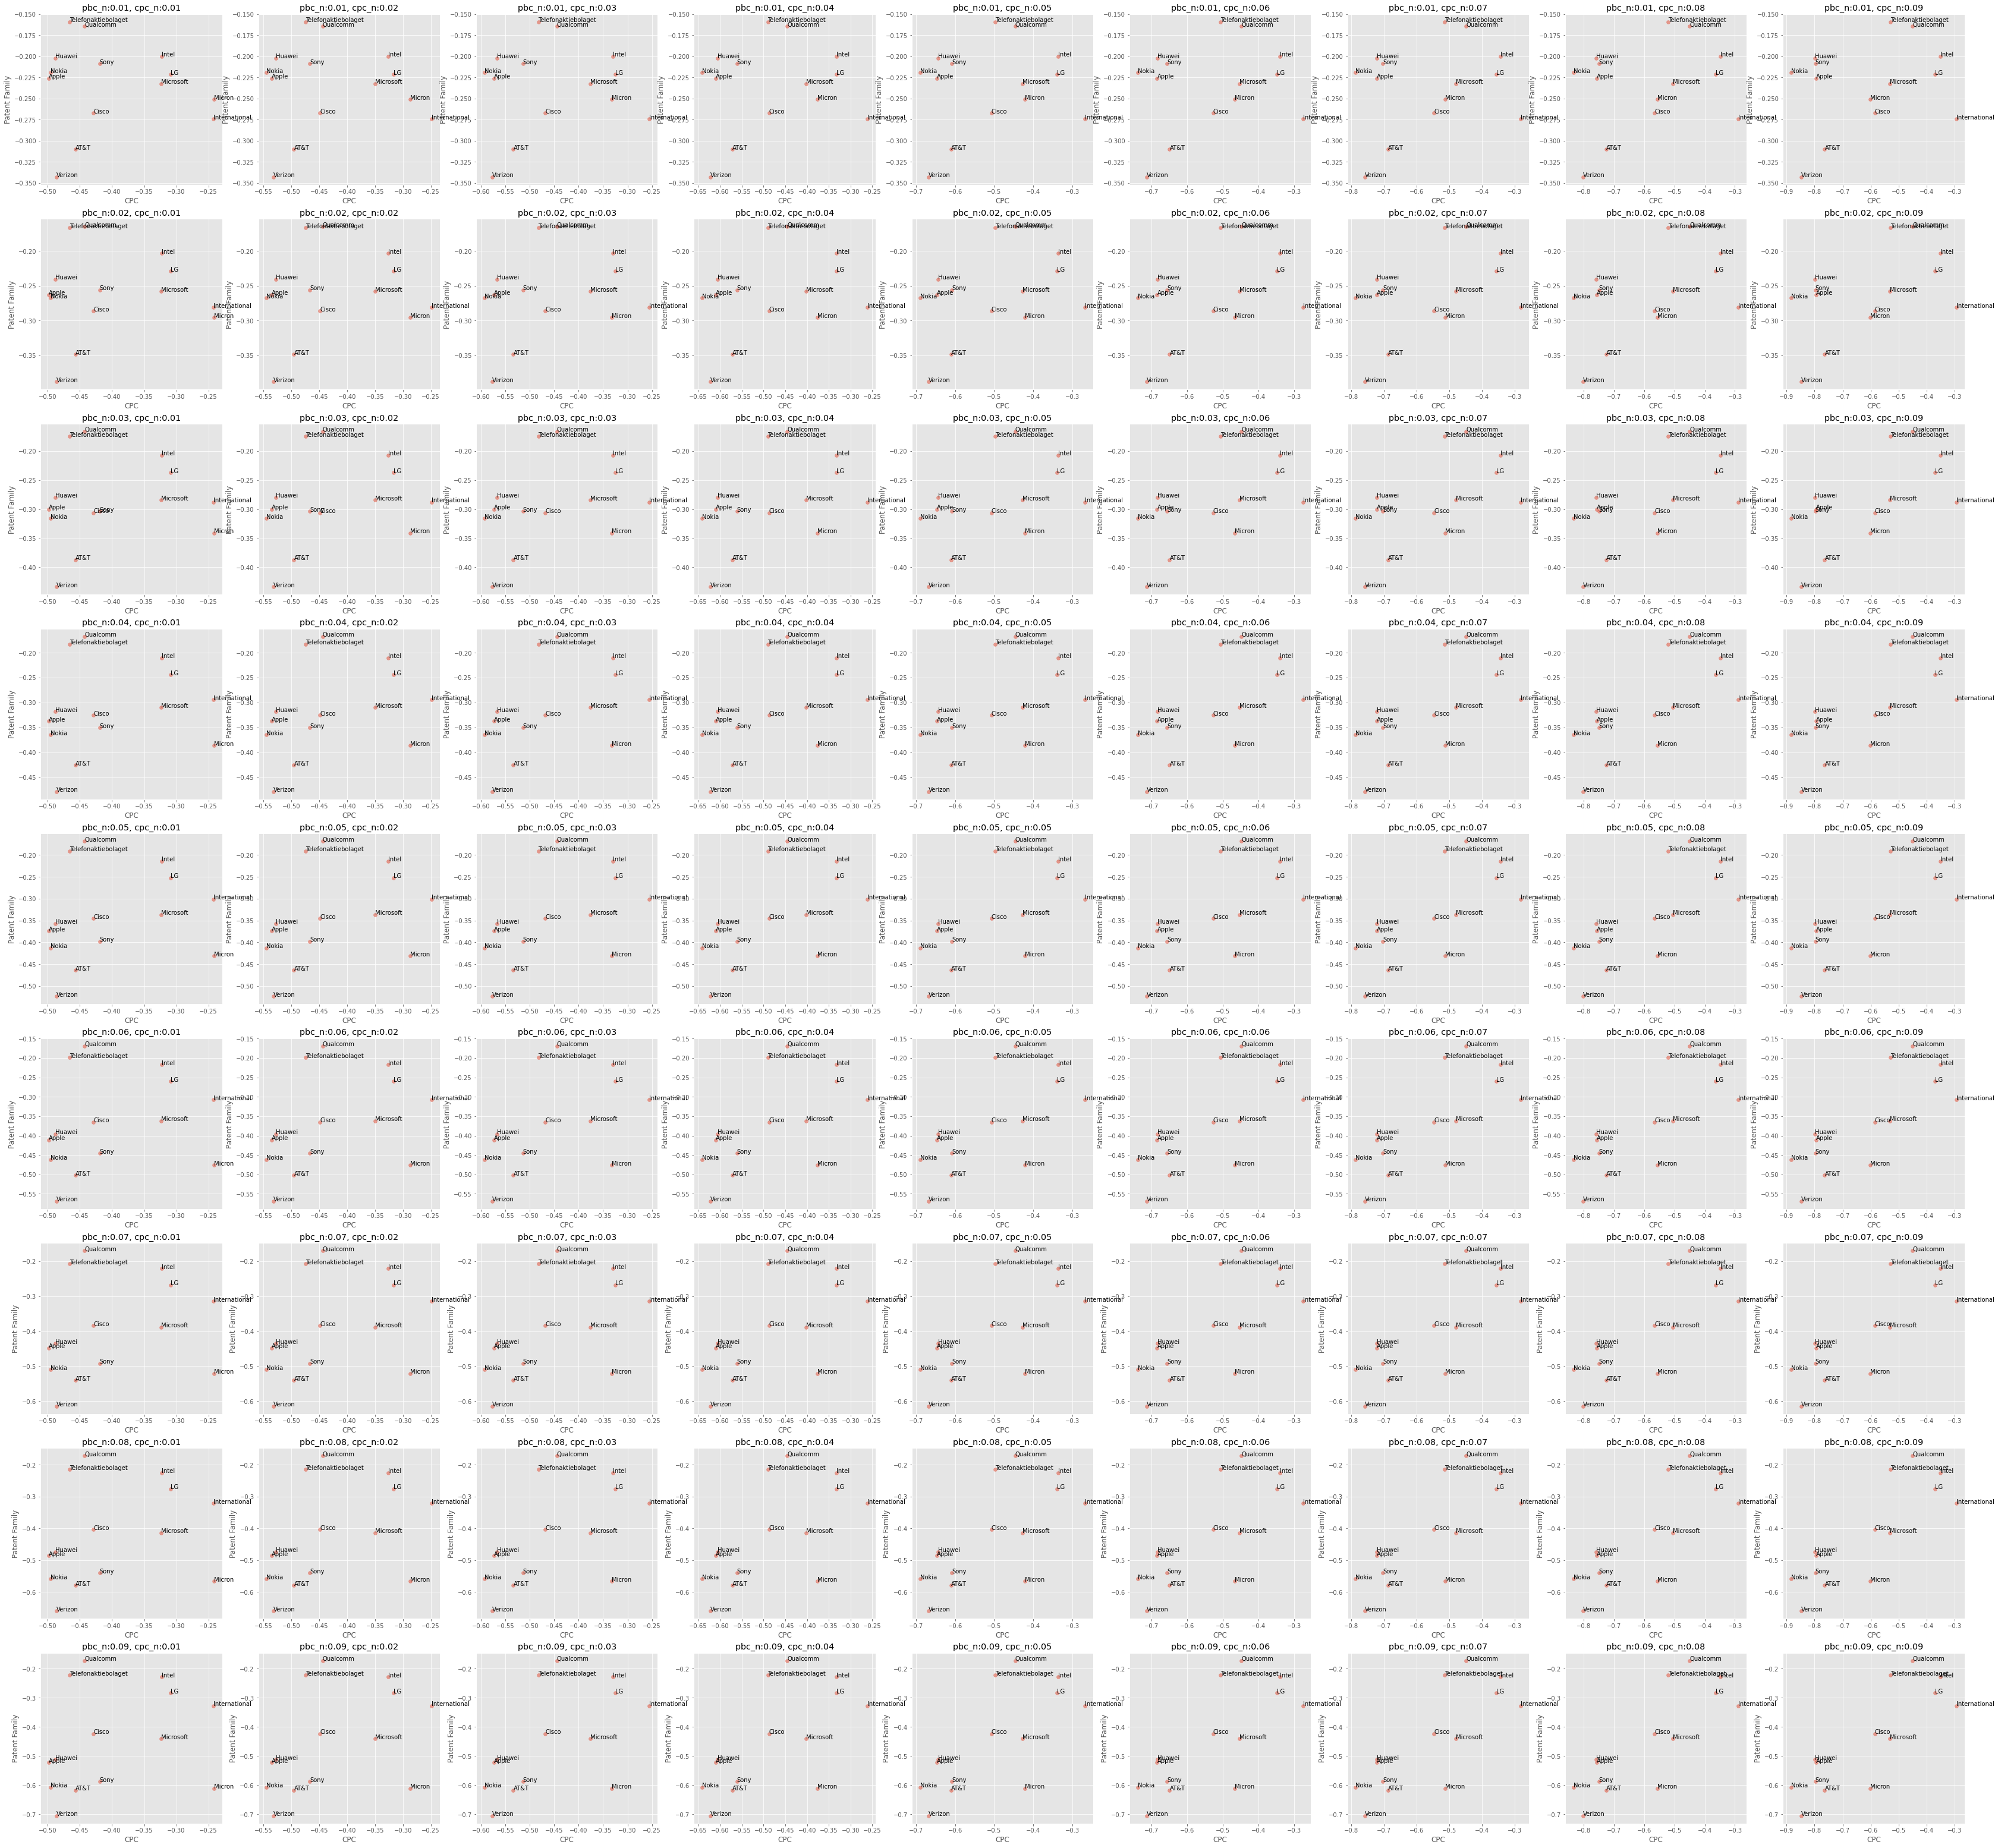

In [39]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_de_us_10_2.png'.format(pbc_n))

In [40]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.450576,0.172228
Intel Corp,0.350771,0.228023
International Business Machines Corp,0.295072,0.327610
LG Electronics Inc,0.370661,0.283109
Telefonaktiebolaget LM Ericsson AB,0.529958,0.222738
Cisco Technology Inc,0.585198,0.423454
Microsoft Technology Licensing LLC,0.531438,0.440082
Apple Inc,0.794722,0.522237
AT&T Intellectual Property I LP,0.763756,0.617289
